# Set up

In [6]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import re
import pickle
import seaborn as sns
from pandas.plotting import parallel_coordinates

# Data

In [ ]:
def extract_data(csv_path, col_name = "estimated_params"):
    df = pd.read_csv(csv_path)
    estimated_params_list = df[col_name].apply(ast.literal_eval).tolist()
    return np.array(estimated_params_list)

In [2]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [ ]:
L_GP_params = extract_data("PlotData/L.GP_21_result.csv")

L_DKGP_params = extract_data("PlotData/L.DKGP_21_result.csv")

L_MGP_params = extract_data("PlotData/L.MGP_21_result.csv")

L_DKMGP_params = extract_data("PlotData/L.DKMGP_21_result.csv")

VGP_params = extract_data("PlotData/VGP_21_result.csv")

MVGP_params = extract_data("PlotData/MVGP_21_result.csv")

DGP_params = extract_data("PlotData/DGP_21_point_result.csv")

DNN_params = extract_data("PlotData/DNN_21_result.csv")

# Plots

In [ ]:
base_dir = "PlotData"

model_files = {
    "L_GP": "L.GP_21_result.csv",
    "L_DKGP": "L.DKGP_21_result.csv", 
    "L_MGP": "L.MGP_21_result.csv",
    "L_DKMGP": "L.DKMGP_21_result.csv",
    "VGP": "VGP_21_result.csv",
    "MVGP": "MVGP_21_result.csv",
    "DGP": "DGP_21_point_result.csv",
    "DNN": "DNN_21_result.csv"
}

## pre

In [ ]:
mse_results = {}
for model, filename in model_files.items():
    est = extract_data(os.path.join(base_dir, filename), col_name = 'test_preds')

    mse_results[model] = np.mean((est - Y_test_21) ** 2)



mse_df = pd.DataFrame.from_dict(mse_results, orient='index', columns=['MSE'])
mse_df.index.name = 'Model'
mse_df = mse_df.reset_index()


print(mse_df)


## Single vs. Multi

In [ ]:
mse_dict = {}
for model, filename in model_files.items():
    est = extract_data(os.path.join(base_dir, filename))

    mse_per_row = np.mean((est - X_test) ** 2, axis=1)
    mse_dict[model] = mse_per_row



mse_df = pd.DataFrame(mse_dict)


In [ ]:
mse_df.mean()

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
plt.ylabel("Mean Squared Error per Sample")
plt.title("Model Comparison")
plt.grid(True, linestyle='--', linewidth=0.5)
# plt.ylim(0, 0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot([mse_df[model] for model in mse_df.columns], labels=mse_df.columns)
ax.set_yscale('log')
ax.set_ylabel("MSE per Sample (log scale)")
ax.set_title("Comparison with Log-scaled Y-axis")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Local vs. Global

In [28]:
DATA_FOLDER = 'PlotData/DNN_21_mcmc_result'
N_SAMPLES = 120
N_POSTERIOR = 1200
N_DIMS = 10

In [22]:
def load_specific_format_data(folder, n_samples):
    """
    专门读取 {'param_0': tensor, ...} 格式的数据
    返回形状: (100, 1200, 10) -> (样本ID, 后验采样ID, 参数维度)
    """
    # 预分配内存
    all_posteriors = np.zeros((n_samples, N_POSTERIOR, N_DIMS))
    
    print(f"{n_samples}...")
    
    for i in range(n_samples):
        file_path = os.path.join(folder, f'result_{i+1}.pkl')
        
        if not os.path.exists(file_path):
            print(f"{file_path}did not exist.")
            continue
            
        with open(file_path, 'rb') as f:
            # data 是一个字典: {'param_0': tensor([...]), ...}
            data_dict = pickle.load(f)
        
        # 将字典转换为 (1200, 10) 的 numpy 数组
        # 我们必须显式循环 0-9，以确保参数顺序正确
        sample_matrix = []
        for dim in range(N_DIMS):
            key = f'param_{dim}'
            if key not in data_dict:
                raise ValueError(f"{file_path} lack {key}")
            
            # 提取 tensor 并转为 numpy
            # .detach().cpu().numpy() 是处理 tensor 的通用安全写法
            tensor_data = data_dict[key]
            numpy_data = tensor_data.detach().cpu().numpy()
            
            sample_matrix.append(numpy_data)
        
        # sample_matrix 目前是 list of 10 arrays (each 1200 length)
        # 使用 column_stack 变成 (1200, 10)
        sample_matrix = np.column_stack(sample_matrix)
        
        # 存入大数组
        all_posteriors[i, :, :] = sample_matrix

    print("Shape:", all_posteriors.shape)
    return all_posteriors

In [29]:
posterior_samples = load_specific_format_data(DATA_FOLDER, N_SAMPLES)

120...
Shape: (120, 1200, 10)


In [24]:
true_params = X_test


Dim   | RMSE       | Bias       | Coverage (Target: 0.95)  
------------------------------------------------------------
0     | 0.0833     | 0.0170     | 0.78   ⚠️ Under
1     | 0.1095     | -0.0254    | 0.87   ⚠️ Under
2     | 0.1023     | -0.0079    | 0.91   
3     | 0.1637     | 0.0116     | 0.91   
4     | 0.0636     | -0.0024    | 0.88   ⚠️ Under
5     | 0.0972     | 0.0007     | 0.90   
6     | 0.0672     | -0.0049    | 0.88   ⚠️ Under
7     | 0.1430     | 0.0018     | 0.86   ⚠️ Under
8     | 0.0431     | 0.0020     | 0.90   
9     | 0.0776     | -0.0079    | 0.93   



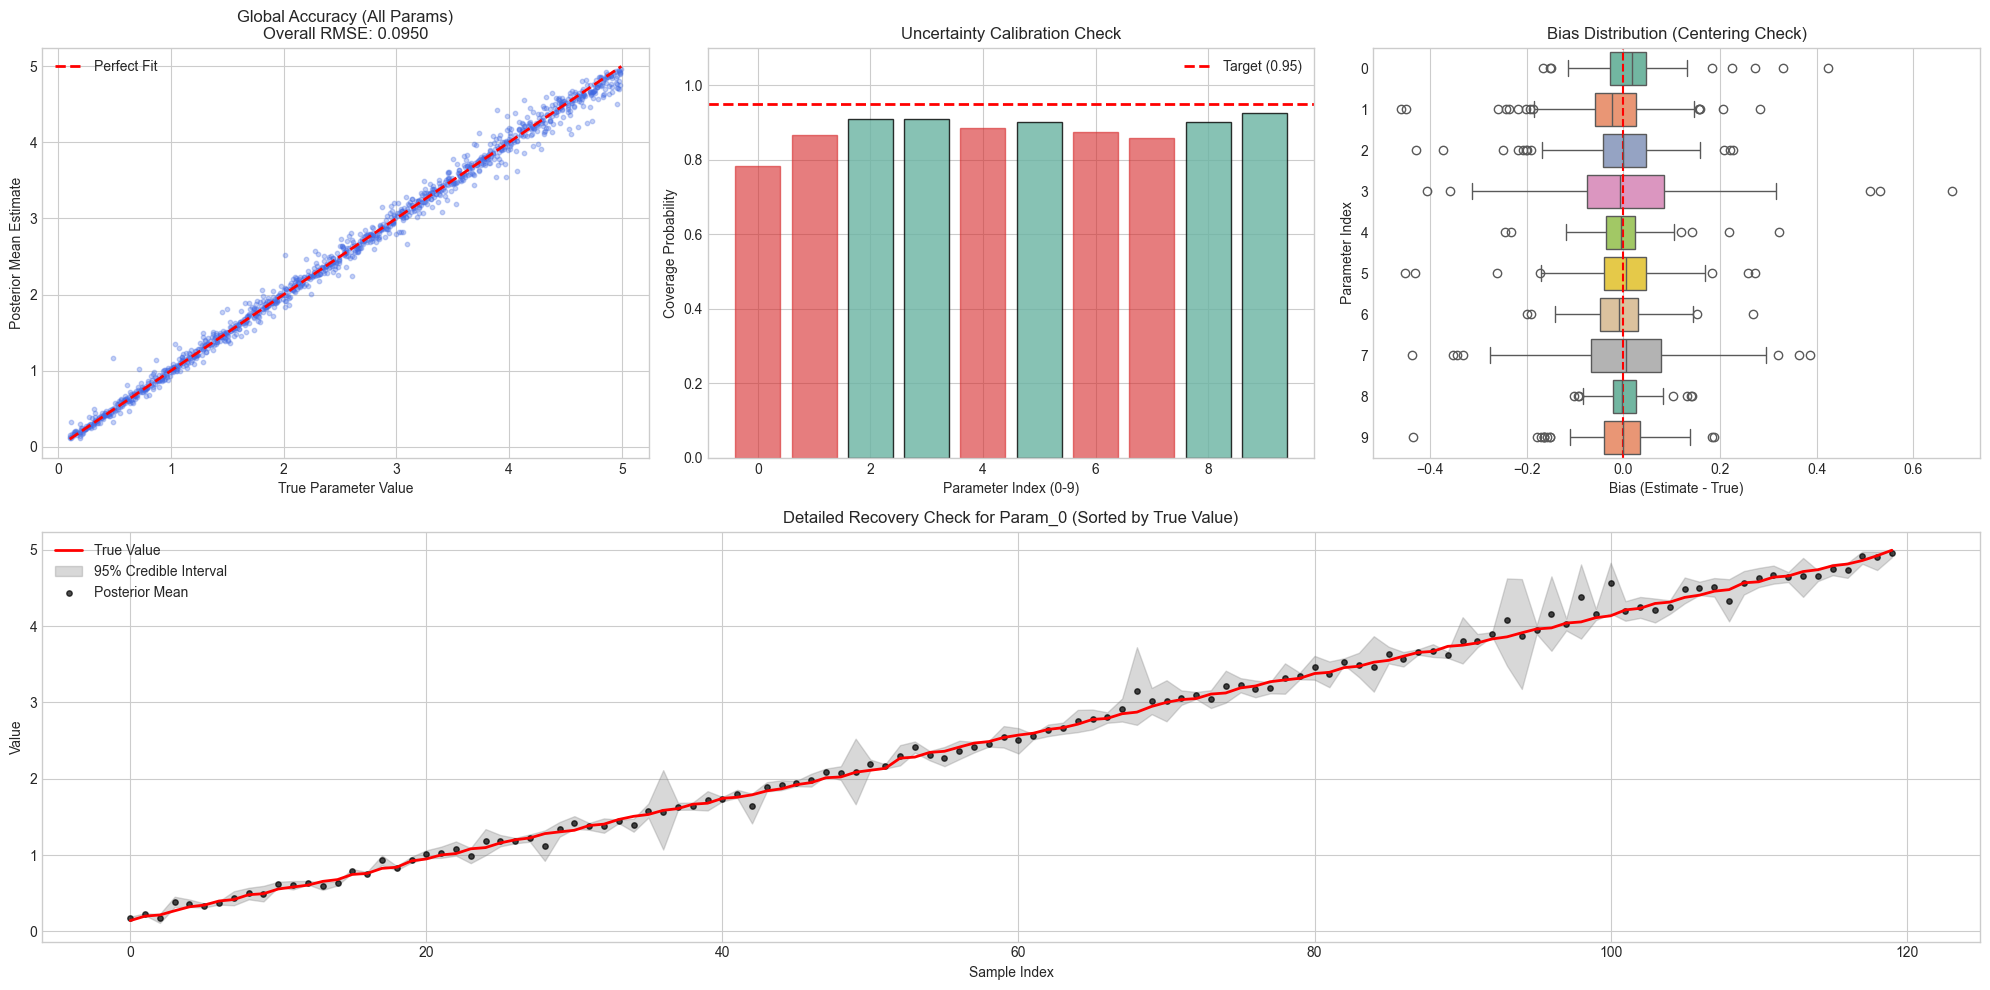

In [30]:

post_mean = np.mean(posterior_samples, axis=1) # 后验均值
lower_ci = np.percentile(posterior_samples, 2.5, axis=1)  # 95% HDI 下界
upper_ci = np.percentile(posterior_samples, 97.5, axis=1) # 95% HDI 上界

# A. RMSE (均方根误差)
rmse = np.sqrt(np.mean((post_mean - true_params)**2, axis=0))

# B. Bias (偏差)
bias = np.mean(post_mean - true_params, axis=0)

# C. Coverage Probability (覆盖率)
# 检查真实值是否在 95% 区间内
is_covered = (true_params >= lower_ci) & (true_params <= upper_ci)
coverage = np.mean(is_covered, axis=0)

# 打印文本报告
print("\n" + "="*60)
print(f"{'Dim':<5} | {'RMSE':<10} | {'Bias':<10} | {'Coverage (Target: 0.95)':<25}")
print("-" * 60)
for i in range(N_DIMS):
    flag = ""
    if coverage[i] < 0.90: flag = "⚠️ Under"
    if coverage[i] > 0.99: flag = "⚠️ Over"
    print(f"{i:<5} | {rmse[i]:<10.4f} | {bias[i]:<10.4f} | {coverage[i]:<6.2f} {flag}")
print("="*60 + "\n")


# ==========================================
# 4. 可视化
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(20, 10))

# --- 图 1: Parity Plot (针对所有维度的均值) ---
ax1 = plt.subplot(2, 3, 1)
# 将所有维度展平画在一起，看整体一致性
ax1.scatter(true_params.flatten(), post_mean.flatten(), alpha=0.3, s=10, c='royalblue')
# 画 y=x 参考线
min_val = min(true_params.min(), post_mean.min())
max_val = max(true_params.max(), post_mean.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
ax1.set_xlabel('True Parameter Value')
ax1.set_ylabel('Posterior Mean Estimate')
ax1.set_title(f'Global Accuracy (All Params)\nOverall RMSE: {np.mean(rmse):.4f}')
ax1.legend()

# --- 图 2: Coverage Probability 柱状图 ---
ax2 = plt.subplot(2, 3, 2)
x_pos = np.arange(N_DIMS)
bars = ax2.bar(x_pos, coverage, color='#69b3a2', alpha=0.8, edgecolor='black')
ax2.axhline(0.95, color='r', linestyle='--', linewidth=2, label='Target (0.95)')
ax2.set_ylim(0, 1.1)
ax2.set_xlabel('Parameter Index (0-9)')
ax2.set_ylabel('Coverage Probability')
ax2.set_title('Uncertainty Calibration Check')
# 在柱状图上标红低覆盖率的
for i, bar in enumerate(bars):
    if coverage[i] < 0.9:
        bar.set_color('#d62728') # 红色警告
        bar.set_alpha(0.6)
ax2.legend()

# --- 图 3: Bias Boxplot (偏差分布) ---
ax3 = plt.subplot(2, 3, 3)
# 计算每个样本每个维度的偏差
bias_distribution = post_mean - true_params 
sns.boxplot(data=bias_distribution, ax=ax3, orient='h', palette="Set2")
ax3.axvline(0, color='r', linestyle='--')
ax3.set_ylabel('Parameter Index')
ax3.set_xlabel('Bias (Estimate - True)')
ax3.set_title('Bias Distribution (Centering Check)')

# --- 图 4: Recovery Plot (针对第 0 个参数的详细检查) ---
ax4 = plt.subplot(2, 1, 2) # 占据下方整行
target_dim = 0 # 查看第一个参数
# 排序
sort_indices = np.argsort(true_params[:, target_dim])
sorted_true = true_params[sort_indices, target_dim]
sorted_mean = post_mean[sort_indices, target_dim]
sorted_lower = lower_ci[sort_indices, target_dim]
sorted_upper = upper_ci[sort_indices, target_dim]

x_axis = np.arange(N_SAMPLES)
ax4.plot(x_axis, sorted_true, 'r-', linewidth=2, label='True Value')
ax4.fill_between(x_axis, sorted_lower, sorted_upper, color='gray', alpha=0.3, label='95% Credible Interval')
ax4.scatter(x_axis, sorted_mean, s=15, color='black', alpha=0.7, label='Posterior Mean')
ax4.set_title(f'Detailed Recovery Check for Param_{target_dim} (Sorted by True Value)')
ax4.set_xlabel('Sample Index')
ax4.set_ylabel('Value')
ax4.legend()

plt.tight_layout()
plt.show()

### test

In [ ]:
ROOT = Path("PlotData")


PKL_PATTERN = re.compile(r"result_(\d+)\.pkl", re.IGNORECASE)

true_params = X_test

have_true = True


In [ ]:
rows: list[dict[str, float]] = []
error_records: list[pd.DataFrame] = []  # for per‑sample error distributions

for model_dir in sorted(ROOT.iterdir()):
    if not model_dir.is_dir():
        continue

    model_name = model_dir.name
    print(f"Scanning {model_name} …")

    pkl_files = sorted(
        (p for p in model_dir.glob("result_*.pkl") if PKL_PATTERN.match(p.name)),
        key=lambda p: int(PKL_PATTERN.search(p.name).group(1))
    )

    for pkl_path in pkl_files:
        run_id = int(PKL_PATTERN.search(pkl_path.name).group(1))

        with pkl_path.open("rb") as fh:
            posterior_dict = pickle.load(fh)

        # (n_draws, 10)
        samples = np.column_stack([
            np.asarray(posterior_dict[f"param_{i}"], dtype=float).ravel()
            for i in range(10)
        ])

        theta_star = true_params[run_id - 1]

        # ── 2.1  Per‑run metrics ──────────────────────────────────────────
        post_mean = samples.mean(axis=0)
        rmse = float(np.sqrt(((post_mean - theta_star) ** 2).mean())) if have_true else np.nan

        lo, hi = np.percentile(samples, [2.5, 97.5], axis=0)
        cover95 = float(((theta_star >= lo) & (theta_star <= hi)).mean()) if have_true else np.nan

        mean_post_sd = float(samples.std(axis=0).mean())

        rows.append({
            "model": model_name,
            "run": run_id,
            "rmse": rmse,
            "cover95": cover95,
            "post_sd": mean_post_sd,
            **{f"phi{i+1}": float(theta_star[i]) for i in range(10)},
        })

        # ── 2.2  Collect per‑sample error for NEW violin plot ─────────────
        if have_true:
            err = samples - theta_star  # shape (n_draws,10)
            df_err = pd.DataFrame(err, columns=[f"phi{i+1}" for i in range(10)])
            df_err = df_err.melt(var_name="param", value_name="error")
            df_err.insert(0, "model", model_name)
            error_records.append(df_err)

print(f"\nLoaded {len(rows)} runs across {len(rows)//120 if rows else 0} models.")

# ------------------------------------------------------------
# 3  DATAFRAME & CSV OUTPUT
# ------------------------------------------------------------

df = pd.DataFrame(rows).sort_values(["model", "run"])
(df if have_true else df.drop(columns=["rmse", "cover95"]))\
    .to_csv(ROOT / "all_runs.csv", index=False)
print("Data table written → all_runs.csv")

# ------------------------------------------------------------
# 4  VISUALISATIONS
# ------------------------------------------------------------

sns.set_theme(style="whitegrid", context="talk")

if have_true:
    # 4.1  RMSE distribution per model
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x="model", y="rmse", palette="Set2", showfliers=False)
    sns.stripplot(data=df, x="model", y="rmse", color="k", size=3, alpha=0.4)
    plt.title("RMSE distribution per model")
    plt.tight_layout()
    plt.savefig(ROOT / "rmse_box.png", dpi=150)

# # 4.2  Parallel‑coordinates (parameters + scaled RMSE if available)
# sc_df = df.copy()
# scale_cols = [f"phi{i}" for i in range(1, 11)] + (["rmse"] if have_true else [])
# for c in scale_cols:
#     span = sc_df[c].max() - sc_df[c].min()
#     sc_df[c] = (sc_df[c] - sc_df[c].min()) / (span + 1e-12)

# plt.figure(figsize=(12, 6))
# parallel_coordinates(
#     sc_df[["model", *scale_cols]],
#     class_column="model", alpha=0.3, linewidth=0.8
# )
# plt.xticks(rotation=45)
# plt.title("Parallel‑coordinates: 10‑D true parameters" + (" + scaled RMSE" if have_true else ""))
# plt.tight_layout()
# plt.savefig(ROOT / "parallel_coords.png", dpi=150)

# # 4.3  PCA scatter (point size ∝ RMSE when available)
# feat_cols = [f"phi{i}" for i in range(1, 11)]
# pca = PCA(n_components=2).fit(df[feat_cols])
# df["PC1"], df["PC2"] = pca.transform(df[feat_cols]).T
# size = 40 + 260 * (df["rmse"] - df["rmse"].min()) / (df["rmse"].max() - df["rmse"].min() + 1e-12) if have_true else 60

# plt.figure(figsize=(6, 5))
# sns.scatterplot(
#     data=df, x="PC1", y="PC2", hue="model", size=size,
#     palette="Set2", sizes=(40, 300) if have_true else None,
#     alpha=0.8, edgecolor="k", legend="brief"
# )
# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
# plt.title("PCA of true parameters" + ("\n(point size ∝ RMSE)" if have_true else ""))
# plt.tight_layout()
# plt.savefig(ROOT / "pca_scatter.png", dpi=150)

# 4.4  NEW: Violin plot of posterior‑sample errors per parameter × model
if have_true and error_records:
    err_df = pd.concat(error_records, ignore_index=True)

    plt.figure(figsize=(16, 8))
    sns.violinplot(data=err_df, x="param", y="error", hue="model",
                   palette="Set2", split=False, cut=0, inner="quartile")
    plt.axhline(0, color="k", lw=.8, ls="--")
    plt.ylabel("Posterior sample − true value")
    plt.title("Distribution of posterior‑sample errors\n(10 parameters × 3 models)")
    plt.tight_layout()
    plt.savefig(ROOT / "error_violin.png", dpi=150)

print("Figures saved: rmse_box.png, parallel_coords.png, pca_scatter.png" + (", error_violin.png" if have_true else ""))

In [ ]:
err_df  

In [ ]:
error_records

# END